## Image rotation with hardware accelerated pixel interpolation

### About hardware sampling

Modern GPUs have dedicate hardware for image sampling. These are able to interpolate pixel values and handle out-of-bound sampling transparently in hardware.
While interpolation is usually restricted to linear and nearest-neighbor sampling, hardware interpolation can significantly accelerate algorithms that depend on massive sampling of image-data.

Here we will rotate an image using the hardware sampler.
Since Numba-CUDA does not implement this feature, we will use the Open Compute Language (OpenCL) with PyOpenCL.
OpenCL is an open, vendor-agnostic standard with similar programming model to CUDA.

### About texture memory

Here we use texture memory for read and interpolate an image through the hardware sampler:

* Texture memory is a read-only, cached access to global device memory.
* It is allocated by host on the device.
* All threads can access texture memory.
* It uses cache locality to speed up access and enables hardware sampling.
* Can convert integer images to “unitized” floating point values.

### Difference OpenCL vs. CUDA:
* In OpenCL (1.2) kernel code cannot be written inline as in CUDA. Instead, the kernel code has to be defined in a separate file or string (as done below).
* While the programming model is similar to CUDA the terminology is different. Here are the relevant correspondences for the example below:

| CUDA | OpenCL|
|---|---|
| SM (Stream Multiprocessor) | CU (Compute Unit) |
| Thread | 	Work-item |
| Block | 	Work-group |
| `blockIdx * blockDim + threadIdx` | `get_global_id()` |

Further information can be found here: [Correspondence of CUDA and OpenCL terminology](https://www.sharcnet.ca/help/index.php/Porting_CUDA_to_OpenCL)

Install PyOpenCL ...

In [1]:
!pip install pyopencl  # install pyopencl package required to run the examples

     |████████████████████████████████| 788kB 8.1MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for pytools: filename=pytools-2021.1-py2.py3-none-any.whl size=60415 sha256=1a5c84d3db993856fa7661cfc57782e7ced4f6b734261bc05b9f5829ee7d33a7
  Stored in directory: /root/.cache/pip/wheels/5d/85/10/7da05d77b47f2cb503e5c4185ba82187d0b6b6736b3c6641e0
Successfully built pytools


### Define kernel

This kernel rotates the image by sampling the image at rotated coordinate positions.
Sampling a rotated coordinates that fall outside of the image are handled in hardware by the sampler depending on how it is initialized.
We pass uniform rotated coordinates (`xpos` and `ypos`) to the sampler.

In [2]:
# kernel definition
ocl_kernel = """
__kernel void img_rotate(
    sampler_t sampler,
    __read_only image2d_t src_data,
    __write_only image2d_t dest_data,
    double sinTheta,
    double cosTheta)
    {
        // work-item gets its index within index space
        const int ix = get_global_id(1);  // corresponds to CUDA: cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        const int iy = get_global_id(0);  // corresponds to CUDA: cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

        // calculate normalized coordinates from work-item index (ix,iy)
        float imageWidth = get_image_width(src_data);
        float imageHeight = get_image_height(src_data);
        float xCenter = .5f;
        float yCenter = .5f;
        float xOffset = ix/imageWidth - xCenter;
        float yOffset = iy/imageHeight - yCenter;
        float xpos = (xOffset*cosTheta + yOffset*sinTheta + xCenter);
        float ypos = (yOffset*cosTheta - xOffset*sinTheta + yCenter);

        // resample image
        const float pxVal = read_imagef(src_data, sampler, (float2)(xpos, ypos)).s0;

        // write to output
        write_imagef(dest_data, (int2)(ix, iy), (float4)(pxVal, 0.0f, 0.0f, 0.0f));
}
"""

### Run kernel to rotate image

This is an example of how to define a sampler from PyOpenCL and pass
it to the kernel. We resample the image so that it is rotated.
* We can change sampler properties for out-of-bounds behavior
and interpolation.
* Coordinates must be uniform for the cl.addressing_mode.REPEAT to work.

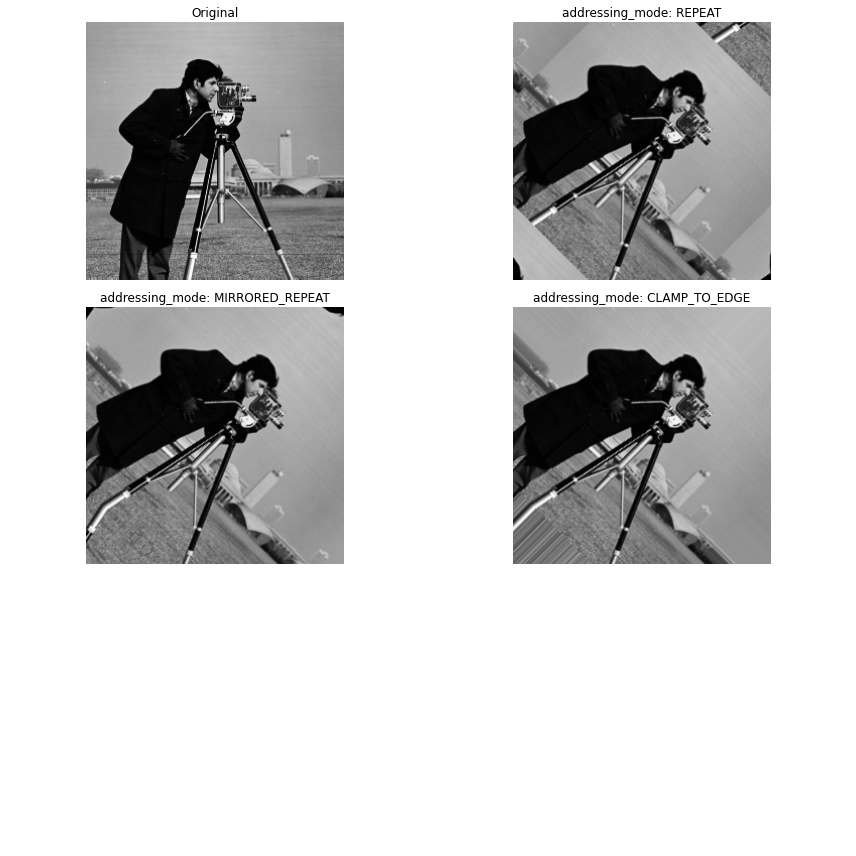

In [3]:
import pyopencl
import numpy as np
import pyopencl as cl
from skimage import filters, io
import matplotlib.pyplot as plt

image_path = "https://homepages.cae.wisc.edu/~ece533/images/cameraman.tif"

# setup OpenCL
platforms = cl.get_platforms()  # a platform corresponds to a driver (e.g. AMD, NVidia, Intel)
platform = platforms[0]  # take first platform
devices = platform.get_devices(cl.device_type.GPU)  # get GPU devices of selected platform
device = devices[0]  # take first GPU
context = cl.Context([device])  # put selected GPU into context object
queue = cl.CommandQueue(context, device)  # create command queue for selected context and GPU

# prepare data
imgIn = io.imread(image_path)

rotation_angle = np.pi/4
cos_theta = np.cos(rotation_angle)
sin_theta = np.sin(rotation_angle)

# setup sampler: this controls sampler out-of-bounds behavior
sampler1 = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.LINEAR)
sampler2 = cl.Sampler(context, True, cl.addressing_mode.MIRRORED_REPEAT, cl.filter_mode.LINEAR)
sampler3 = cl.Sampler(context, True, cl.addressing_mode.CLAMP_TO_EDGE, cl.filter_mode.LINEAR)
# sampler4 = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.NEAREST)

samplers = [sampler1, sampler2, sampler3]
addressing_modes = ['REPEAT', 'MIRRORED_REPEAT', 'CLAMP_TO_EDGE']

# get shape of input image, allocate memory for output to which result can be copied to
shape = imgIn.T.shape
imgOut = np.empty_like(imgIn)

# create image buffers which hold images for OpenCL
imgInBuf = cl.image_from_array(context, ary=imgIn, mode="r", norm_int=True, num_channels=1)
imgOutBuf = cl.image_from_array(context, ary=imgOut, mode="w", norm_int=True, num_channels=1)

# load, compile and execute OpenCL program
program = cl.Program(context, ocl_kernel).build()

# show images
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(12, 12))
axes = axes.flatten()

axes[0].imshow(imgIn, cmap=plt.cm.gray)
axes[0].set_title('Original')
for ind, sampler in enumerate(samplers):
    program.img_rotate(queue, shape, None, sampler, imgInBuf, imgOutBuf, np.double(sin_theta), np.double(cos_theta))
    cl.enqueue_copy(queue, imgOut, imgOutBuf, origin=(0, 0), region=shape,
                    is_blocking=True)  # wait until finished copying resulting image back from GPU to CPU

    axes[ind+1].imshow(imgOut, cmap=plt.cm.gray)
    axes[ind+1].set_title(f'addressing_mode: {addressing_modes[ind]}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

Resources:
* pyopencl documentation: https://documen.tician.de/pyopencl/index.html
* Correspondence of CUDA and OpenCL terminology: https://www.sharcnet.ca/help/index.php/Porting_CUDA_to_OpenCL